## Практика. Дерево решений в задаче предсказания выживания пассажиров "Титаника". Решение

**Заполните код в клетках и выберите ответы в [веб-форме](https://goo.gl/TBwVhQ).**

**<a href="https://www.kaggle.com/c/titanic">Соревнование</a> Kaggle "Titanic: Machine Learning from Disaster".**

In [3]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier, export_graphviz

%matplotlib inline
import seaborn as sns
from matplotlib import pyplot as plt

**Функция для формирования csv-файла посылки на Kaggle:**

In [ ]:
def write_to_submission_file(
    predicted_labels,
    out_file,
    train_num=891,
    target="Survived",
    index_label="PassengerId",
):
    # turn predictions into data frame and save as csv file
    predicted_df = pd.DataFrame(
        predicted_labels,
        index=np.arange(train_num + 1, train_num + 1 + predicted_labels.shape[0]),
        columns=[target],
    )
    predicted_df.to_csv(out_file, index_label=index_label)

**Считываем обучающую и тестовую выборки.**

In [46]:
train_df = pd.read_csv("./data/titanic_train.csv")
test_df = pd.read_csv("./data/titanic_test.csv")

In [7]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [13]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [11]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [ ]:
test_df.describe(include="all")

In [15]:
test_df.value_counts

<bound method DataFrame.value_counts of      PassengerId  Pclass                                          Name  \
0            892       3                              Kelly, Mr. James   
1            893       3              Wilkes, Mrs. James (Ellen Needs)   
2            894       2                     Myles, Mr. Thomas Francis   
3            895       3                              Wirz, Mr. Albert   
4            896       3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)   
..           ...     ...                                           ...   
413         1305       3                            Spector, Mr. Woolf   
414         1306       1                  Oliva y Ocana, Dona. Fermina   
415         1307       3                  Saether, Mr. Simon Sivertsen   
416         1308       3                           Ware, Mr. Frederick   
417         1309       3                      Peter, Master. Michael J   

        Sex   Age  SibSp  Parch              Ticket      Fare Cabin Emb

**Заполним пропуски медианными значениями.**

In [48]:
train_df["Age"].fillna(train_df["Age"].median(), inplace=True)
test_df["Age"].fillna(train_df["Age"].median(), inplace=True)
train_df["Embarked"].fillna("S", inplace=True)
test_df["Fare"].fillna(train_df["Fare"].median(), inplace=True)

**Кодируем категориальные признаки `Pclass`, `Sex`, `SibSp`, `Parch` и `Embarked` с помощью техники One-Hot-Encoding.**

In [51]:
train_df = pd.concat(
    [
        train_df,
        pd.get_dummies(train_df["Pclass"], prefix="PClass"),
        pd.get_dummies(train_df["Sex"], prefix="Sex"),
        pd.get_dummies(train_df["SibSp"], prefix="SibSp"),
        pd.get_dummies(train_df["Parch"], prefix="Parch"),
        pd.get_dummies(train_df["Embarked"], prefix="Embarked"),
    ],
    axis=1,
)
test_df = pd.concat(
    [
        test_df,
        pd.get_dummies(test_df["Pclass"], prefix="PClass"),
        pd.get_dummies(test_df["Sex"], prefix="Sex"),
        pd.get_dummies(test_df["SibSp"], prefix="SibSp"),
        pd.get_dummies(test_df["Parch"], prefix="Parch"),
        pd.get_dummies(test_df["Embarked"], prefix="Embarked"),
    ],
    axis=1,
)

In [53]:
train_df.drop(
    [
        "Pclass",
        "Name",
        "SibSp",
        "Parch",
        "Ticket",
        "Cabin",
        "Embarked",
        "Sex",
    ],
    axis=1,
    inplace=True,
)
test_df.drop(
    [
        "Pclass",
        "Name",
        "SibSp",
        "Parch",
        "Ticket",
        "Cabin",
        "Embarked",
        "Sex",
    ],
    axis=1,
    inplace=True,
)

**В тестовой выборке появляется новое значение Parch = 9, которого нет в обучающей выборке. Проигнорируем его.**

In [23]:
train_df.shape, test_df.shape

((891, 27), (418, 27))

In [25]:
set(test_df.columns) - set(train_df.columns)

{'Parch_9'}

In [55]:
test_df.drop(["Parch_9"], axis=1, inplace=True)

In [57]:
train_df.head()

,PassengerId,Survived,Age,Fare,PClass_1,PClass_2,PClass_3,Sex_female,Sex_male,SibSp_0,...,Parch_0,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Embarked_C,Embarked_Q,Embarked_S
0,1,0,22.0,7.2500,False,False,True,False,True,False,...,True,False,False,False,False,False,False,False,False,True
1,2,1,38.0,71.2833,True,False,False,True,False,False,...,True,False,False,False,False,False,False,True,False,False
2,3,1,26.0,7.9250,False,False,True,True,False,True,...,True,False,False,False,False,False,False,False,False,True
3,4,1,35.0,53.1000,True,False,False,True,False,False,...,True,False,False,False,False,False,False,False,False,True
4,5,0,35.0,8.0500,False,False,True,False,True,True,...,True,False,False,False,False,False,False,False,False,True


In [59]:
test_df.head()

,PassengerId,Age,Fare,PClass_1,PClass_2,PClass_3,Sex_female,Sex_male,SibSp_0,SibSp_1,...,Parch_0,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Embarked_C,Embarked_Q,Embarked_S
0,892,34.5,7.8292,False,False,True,False,True,True,False,...,True,False,False,False,False,False,False,False,True,False
1,893,47.0,7.0000,False,False,True,True,False,False,True,...,True,False,False,False,False,False,False,False,False,True
2,894,62.0,9.6875,False,True,False,False,True,True,False,...,True,False,False,False,False,False,False,False,True,False
3,895,27.0,8.6625,False,False,True,False,True,True,False,...,True,False,False,False,False,False,False,False,False,True
4,896,22.0,12.2875,False,False,True,True,False,False,True,...,False,True,False,False,False,False,False,False,False,True


## 1. Дерево решений без настройки параметров 

**Обучите на имеющейся выборке дерево решений (`DecisionTreeClassifier`) максимальной глубины 2. Используйте параметр `random_state=17` для воспроизводимости результатов.**

In [61]:
y = train_df['Survived']

In [70]:
X = train_df.drop(columns=['PassengerId', 'Survived'])

In [72]:
X.info()
X

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 24 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Age         891 non-null    float64
 1   Fare        891 non-null    float64
 2   PClass_1    891 non-null    bool   
 3   PClass_2    891 non-null    bool   
 4   PClass_3    891 non-null    bool   
 5   Sex_female  891 non-null    bool   
 6   Sex_male    891 non-null    bool   
 7   SibSp_0     891 non-null    bool   
 8   SibSp_1     891 non-null    bool   
 9   SibSp_2     891 non-null    bool   
 10  SibSp_3     891 non-null    bool   
 11  SibSp_4     891 non-null    bool   
 12  SibSp_5     891 non-null    bool   
 13  SibSp_8     891 non-null    bool   
 14  Parch_0     891 non-null    bool   
 15  Parch_1     891 non-null    bool   
 16  Parch_2     891 non-null    bool   
 17  Parch_3     891 non-null    bool   
 18  Parch_4     891 non-null    bool   
 19  Parch_5     891 non-null    b

,Age,Fare,PClass_1,PClass_2,PClass_3,Sex_female,Sex_male,SibSp_0,SibSp_1,SibSp_2,...,Parch_0,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Embarked_C,Embarked_Q,Embarked_S
0,22.0,7.2500,False,False,True,False,True,False,True,False,...,True,False,False,False,False,False,False,False,False,True
1,38.0,71.2833,True,False,False,True,False,False,True,False,...,True,False,False,False,False,False,False,True,False,False
2,26.0,7.9250,False,False,True,True,False,True,False,False,...,True,False,False,False,False,False,False,False,False,True
3,35.0,53.1000,True,False,False,True,False,False,True,False,...,True,False,False,False,False,False,False,False,False,True
4,35.0,8.0500,False,False,True,False,True,True,False,False,...,True,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,27.0,13.0000,False,True,False,False,True,True,False,False,...,True,False,False,False,False,False,False,False,False,True
887,19.0,30.0000,True,False,False,True,False,True,False,False,...,True,False,False,False,False,False,False,False,False,True
888,28.0,23.4500,False,False,True,True,False,False,True,False,...,False,False,True,False,False,False,False,False,False,True
889,26.0,30.0000,True,False,False,False,True,True,False,False,...,True,False,False,False,False,False,False,True,False,False


In [119]:
grid_clf = DecisionTreeClassifier(random_state=17)
grid_clf.fit(X, y)

y_pred = grid_clf.predict(X)
print(accuracy_score(y, y_pred))

0.9797979797979798


In [121]:
X_test = test_df.drop(columns=['PassengerId'])
test_predictions = grid_clf.predict(X_test)

In [123]:
predict_df = pd.DataFrame({
    "PassengerID": test_df['PassengerId'],
    "Survived": test_predictions
})

display(predict_df)

predict_df.Survived.value_counts()

,PassengerID,Survived
0,892,0
1,893,0
2,894,1
3,895,1
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


Survived
0    260
1    158
Name: count, dtype: int64

<font color='red'>Вопрос 1. </font> Каков результат первой посылки (дерево решений без настройки параметров) в публичном рейтинге соревнования Titanic?
- 0.746
- 0.756
- 0.766
- 0.776

**Отобразите дерево с помощью `export_graphviz` и `dot`.**

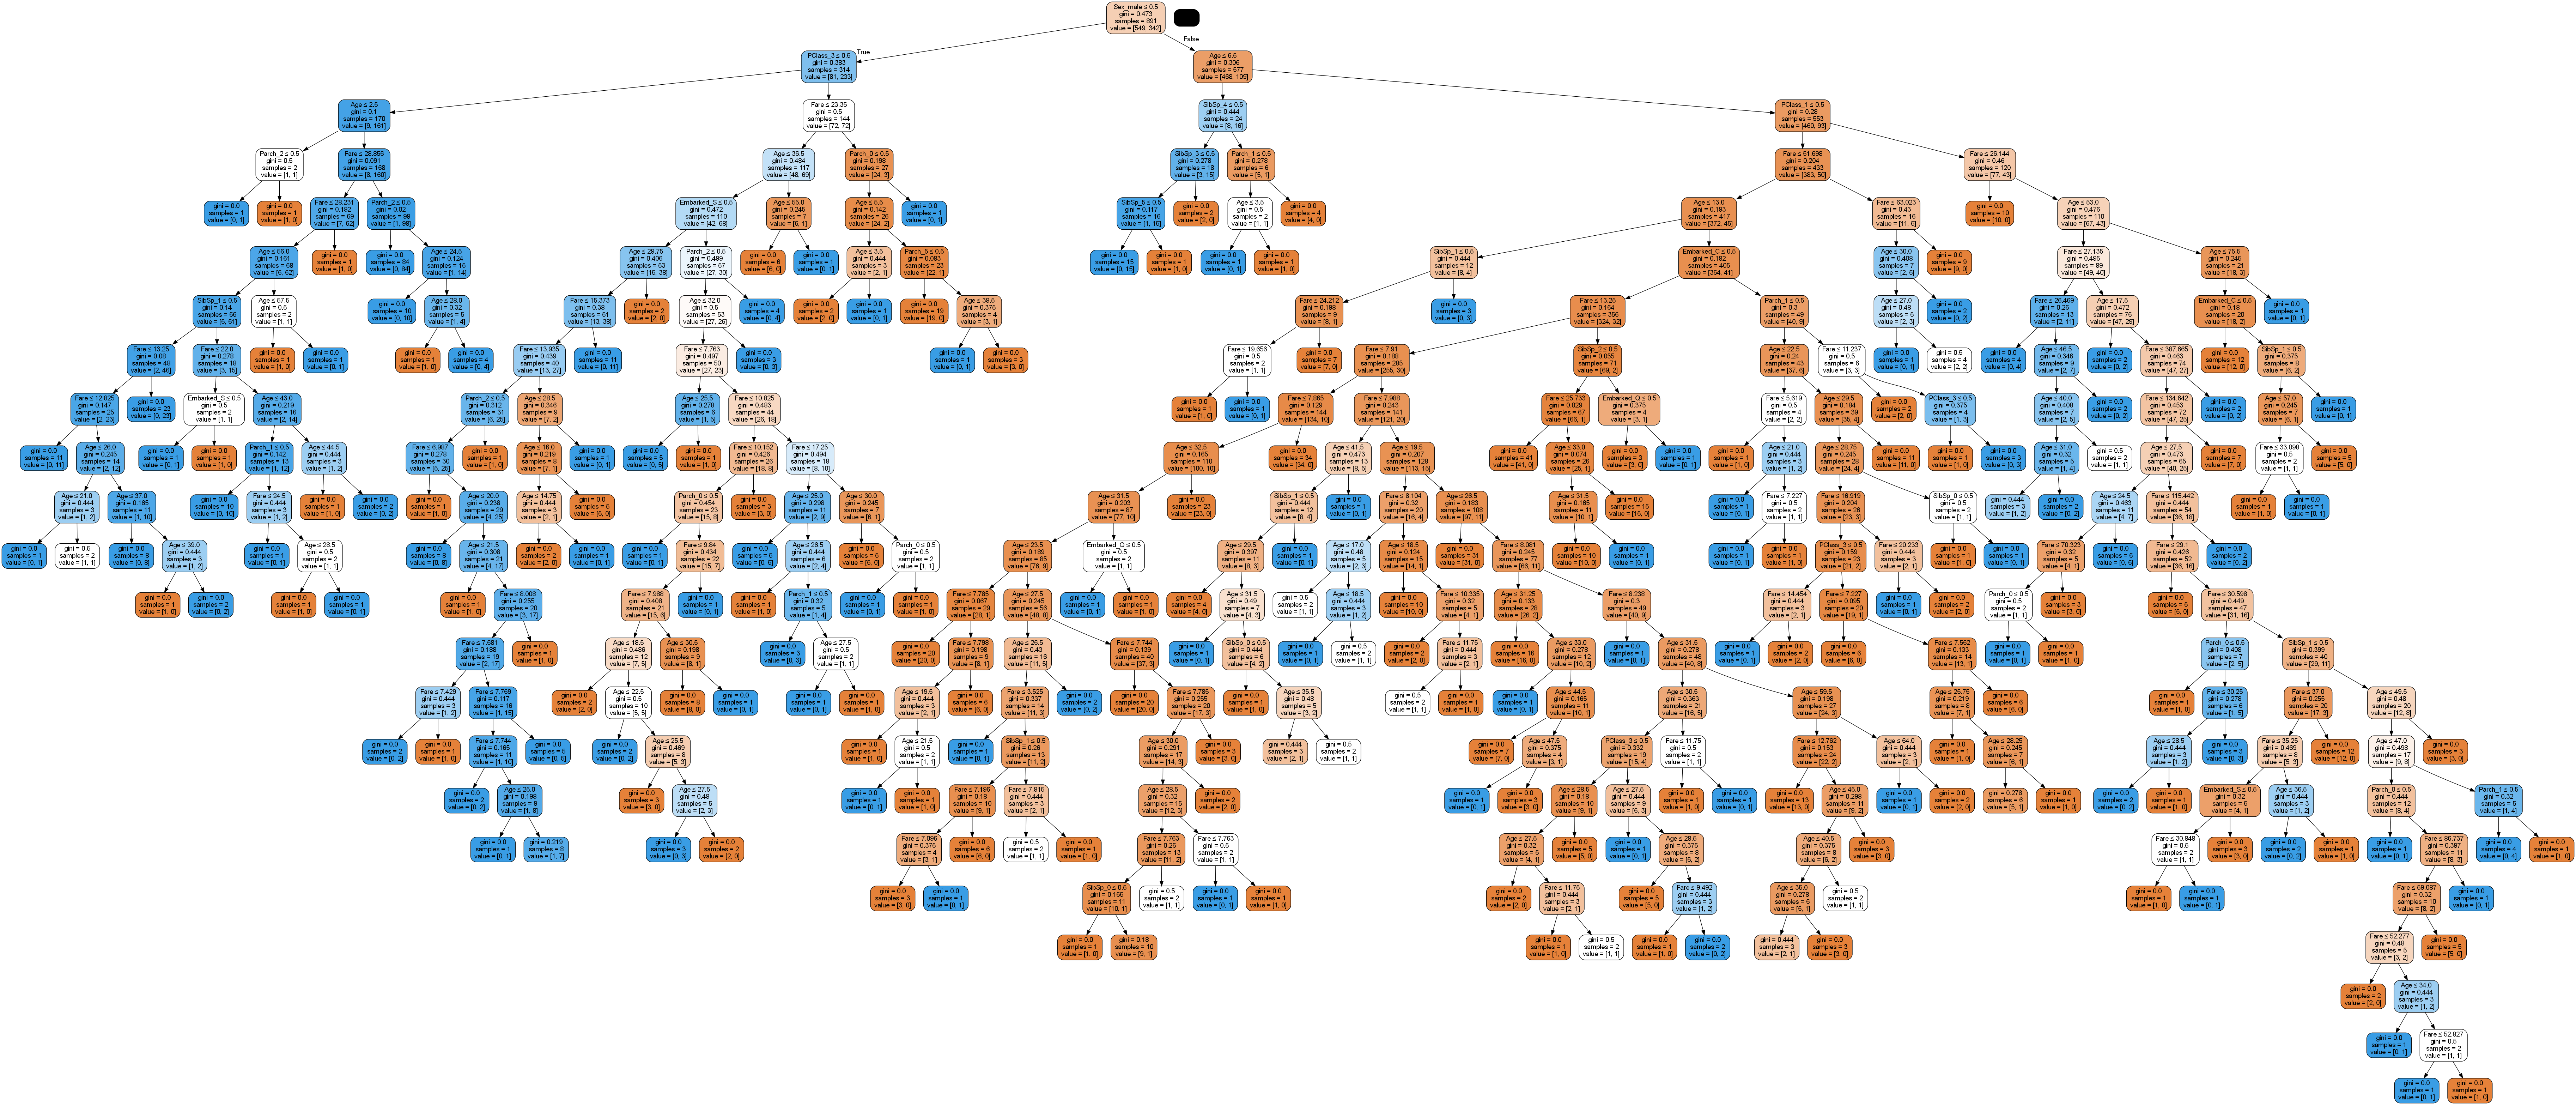

In [125]:
from io import StringIO
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus

# Экспорт дерева решений в формат .dot и создание графа
dot_data = StringIO()
export_graphviz(grid_clf, feature_names=X.columns, out_file=dot_data, filled=True, rounded=True, special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

# Отображение графа дерева решений
Image(graph.create_png())

<font color='red'>Вопрос 2. </font> Сколько признаков задействуются при прогнозе деревом решений глубины 2?
- 2
- 3
- 4
- 5

## 2. Дерево решений с настройкой параметров 

**Обучите на имеющейся выборке дерево решений (`DecisionTreeClassifier`). Также укажите `random_state=17`. Максимальную глубину и минимальное число элементов в листе настройте на 5-кратной кросс-валидации с помощью `GridSearchCV`.**

In [103]:
# tree params for grid search
tree_params = {"max_depth": list(range(1, 10)), "min_samples_leaf": list(range(1, 15))}

tree_clf = DecisionTreeClassifier(random_state=17)

grid_search = GridSearchCV(tree_clf, tree_params, cv=5, scoring='accuracy')

grid_search.fit(X, y)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=17),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                              12, 13, 14]},
             scoring='accuracy')

In [105]:
best_tree_clf = grid_search.best_estimator_
grid_search.best_params_


{'max_depth': 7, 'min_samples_leaf': 6}

In [107]:
grid_search.best_score_

0.8249325214989642

<font color='red'>Вопрос 3. </font> Каковы лучшие параметры дерева, настроенные на кросс-валидации с помощью `GridSearchCV`?
- max_depth=2, min_samples_leaf=1
- max_depth=2, min_samples_leaf=4
- max_depth=3, min_samples_leaf=2
- max_depth=3, min_samples_leaf=3

<font color='red'>Вопрос 4. </font> Какой получилась средняя доля верных ответов на кросс-валидации для дерева решений с лучшим сочетанием гиперпараметров `max_depth` и `min_samples_leaf`?
- 0.77
- 0.79
- 0.81
- 0.83